# **`Airbnb Price Prediction Project`**

## Airbnb Price Prediction ‚Äì Machine Learning Project

Objectif du projet :

L'objectif est de pr√©dire le **logarithme du prix** (`log_price`) des annonces Airbnb √† partir d‚Äôun ensemble de caract√©ristiques disponibles pour chaque logement.

Nous devons :
- Explorer et comprendre les donn√©es (EDA)
- Nettoyer et transformer les variables (pr√©traitement & feature engineering)
- Entra√Æner et comparer plusieurs mod√®les de machine learning
- G√©n√©rer un fichier de pr√©dictions final sur un jeu test inconnu

---

Donn√©es disponibles :

- `airbnb_train.csv` ‚Üí donn√©es d'entra√Ænement avec la cible `log_price`
- `airbnb_test.csv` ‚Üí donn√©es de test sans la variable cible
- `prediction_example.csv` ‚Üí format attendu du fichier final
- Chaque ligne = une annonce Airbnb

---

Variables principales (exemples) :

- **Cat√©gorielles** : `room_type`, `property_type`, `bed_type`
- **Num√©riques** : `accommodates`, `bedrooms`, `review_scores_rating`
- **Textuelles** : `name`, `description`, `amenities`
- **G√©ographiques** : `latitude`, `longitude`
- **Cible** : `log_price` (logarithme du prix)

## 1 - Importation des biblioth√®ques

In [5]:
# Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Options d'affichage
pd.set_option('display.max_columns', 100)

## 2 - Charger les donn√©es et les explorer

In [3]:
# Chargement du fichier airbnb_train.csv
df_train = pd.read_csv('airbnb_train.csv')

# Aper√ßu du dataset
print("Dimensions :", df_train.shape)
df_train.head()

Dimensions : (22234, 28)


id  log_price property_type        room_type  \
0   5708593   4.317488         House     Private room   
1  14483613   4.007333         House     Private room   
2  10412649   7.090077     Apartment  Entire home/apt   
3  17954362   3.555348         House     Private room   
4   9969781   5.480639         House  Entire home/apt   

                                           amenities  accommodates  bathrooms  \
0  {TV,"Wireless Internet",Kitchen,"Free parking ...             3        1.0   
1  {"Wireless Internet","Air conditioning",Kitche...             4        2.0   
2  {TV,"Wireless Internet","Air conditioning",Kit...             6        2.0   
3  {TV,"Cable TV",Internet,"Wireless Internet","A...             1        1.0   
4  {TV,"Cable TV",Internet,"Wireless Internet",Ki...             4        1.0   

   bed_type cancellation_policy  cleaning_fee  ... last_review   latitude  \
0  Real Bed            flexible         False  ...         NaN  33.782712   
1  Real Bed              strict         False  ...  2017-09-17  40.705468   
2  Real Bed            flexible         False  ...         NaN  38.917537   
3  Real Bed            flexible          True  ...  2017-09-29  40.736001   
4  Real Bed            moderate          True  ...  2017-08-28  37.744896   

    longitude                                               name  \
0 -118.134410                            Island style Spa Studio   
1  -73.909439  Beautiful and Simple Room W/2 Beds, 25 Mins to...   
2  -77.031651  2br/2ba luxury condo perfect for infant / toddler   
3  -73.924248   Manhattan view from Queens. Lovely single room .   
4 -122.430665                      Zen Captured Noe Valley House   

       neighbourhood number_of_reviews review_scores_rating zipcode bedrooms  \
0         Long Beach                 0                  NaN   90804      0.0   
1          Ridgewood                38                 86.0   11385      1.0   
2  U Street Corridor                 0                  NaN   20009      2.0   
3          Sunnyside                19                 96.0   11104      1.0   
4         Noe Valley                15                 96.0   94131      2.0   

   beds  
0   2.0  
1   2.0  
2   2.0  
3   1.0  
4   2.0  

[5 rows x 28 columns]

## 3 - Types de variables & valeurs manquantes

In [7]:
# Types de variables
df_train.dtypes

# Valeurs manquantes
missing = df_train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Variables avec valeurs manquantes :")
missing

Variables avec valeurs manquantes :


host_response_rate        5475
review_scores_rating      4978
first_review              4725
last_review               4716
neighbourhood             2086
zipcode                    303
host_has_profile_pic        56
host_identity_verified      56
host_since                  56
bathrooms                   51
beds                        35
bedrooms                    26
dtype: int64

Commentaires :
 Plusieurs colonnes du dataset pr√©sentent des **valeurs manquantes** :

- `host_response_rate`, `review_scores_rating`, `first_review`, `last_review` :
  Ces variables li√©es aux **√©valuations et √† l'activit√© du logement** sont les plus concern√©es, avec plus de **4 000 valeurs manquantes** chacune.

## 4 - Visualisation des valeurs manquantes

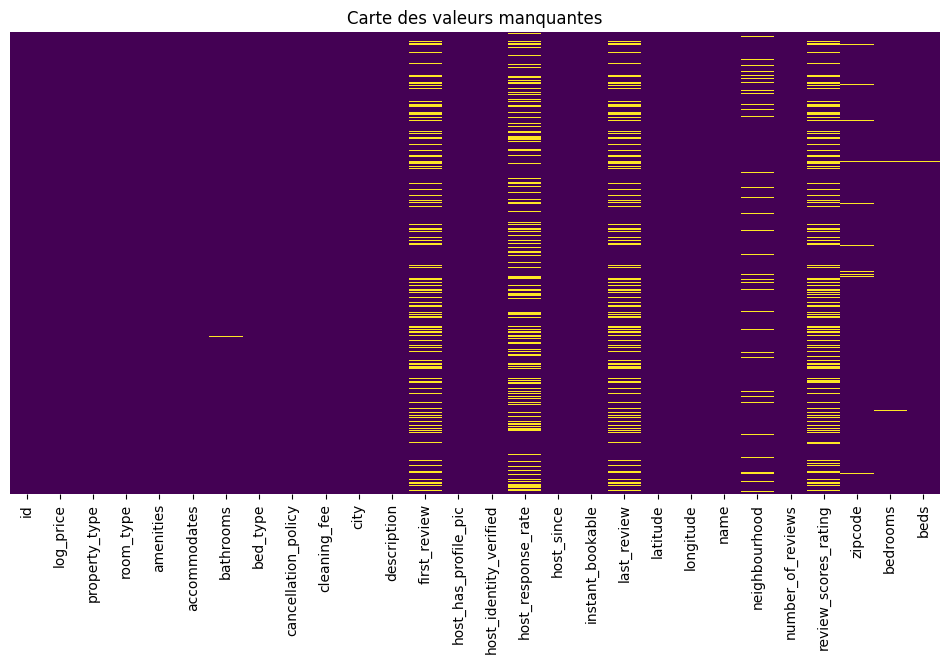

In [8]:
# Heatmap des valeurs manquantes
plt.figure(figsize=(12,6))
sns.heatmap(df_train.isnull(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Carte des valeurs manquantes")
plt.show()

## 5 - Distribution de la cible log_price

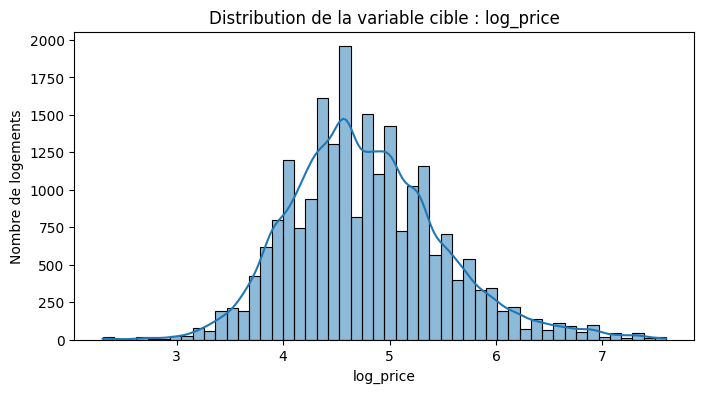

In [9]:
# Distribution de log_price
plt.figure(figsize=(8,4))
sns.histplot(df_train['log_price'], bins=50, kde=True)
plt.title("Distribution de la variable cible : log_price")
plt.xlabel("log_price")
plt.ylabel("Nombre de logements")
plt.show()


commentaires :
- La variable `log_price` est **presque normale**, avec un l√©ger biais √† droite.
- La majorit√© des logements ont un log_price entre **4.5 et 5.5** (~90 √† 245 ‚Ç¨).
- Quelques logements tr√®s chers cr√©ent une **queue √† droite**.
- Bonne distribution pour un mod√®le de r√©gression.

## Traitement des valeurs manquantes

In [11]:
# Copie du dataset pour le pr√©traitement
df = df_train.copy()

# host_response_rate ‚Üí convertir en pourcentage
df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype(float)

# Conversion des dates
df['host_since'] = pd.to_datetime(df['host_since'])
df['first_review'] = pd.to_datetime(df['first_review'])
df['last_review'] = pd.to_datetime(df['last_review'])

# Cr√©ation de l'anciennet√© de l'h√¥te
df['host_experience_years'] = pd.to_datetime("2018-01-01") - df['host_since']
df['host_experience_years'] = df['host_experience_years'].dt.days // 365

# Imputations sans 'inplace' pour √©viter les warnings
df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].median())
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].median())
df['beds'] = df['beds'].fillna(df['beds'].median())
df['review_scores_rating'] = df['review_scores_rating'].fillna(df['review_scores_rating'].median())
df['host_response_rate'] = df['host_response_rate'].fillna(df['host_response_rate'].median())
df['zipcode'] = df['zipcode'].fillna("unknown")
df['neighbourhood'] = df['neighbourhood'].fillna("unknown")
df['host_experience_years'] = df['host_experience_years'].fillna(0)

## Encodage des variables cat√©gorielles

In [12]:
# Colonnes cat√©gorielles √† encoder
categorical_cols = [
    'room_type',
    'property_type',
    'bed_type',
    'cancellation_policy',
    'instant_bookable',
    'cleaning_fee',
    'host_has_profile_pic',
    'host_identity_verified'
]

# Convertir en type string au cas o√π
df[categorical_cols] = df[categorical_cols].astype(str)

# Encodage One-Hot
df_encoded = pd.get_dummies(df[categorical_cols], drop_first=True)

#  Fusion avec le dataset d'origine
df_model = pd.concat([df, df_encoded], axis=1)

#  Suppression des anciennes colonnes textuelles
df_model.drop(columns=categorical_cols, inplace=True)


In [13]:
#  Colonnes num√©riques qu'on garde
numerical_cols = [
    'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'review_scores_rating', 'number_of_reviews',
    'latitude', 'longitude', 'host_response_rate', 'host_experience_years'
]

#  On garde aussi la variable cible
target_col = 'log_price'

#  Colonnes finales = num√©riques + colonnes encod√©es (d√©j√† dans df_model)
X = df_model[numerical_cols + list(df_model.columns[df_model.columns.str.startswith(tuple(categorical_cols))])]
y = df_model[target_col]


## Partie II : Mod√®le de base : Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

#  S√©paration entra√Ænement / validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#  Mod√®le de base
lr = LinearRegression()
lr.fit(X_train, y_train)

#  Pr√©dictions
y_pred = lr.predict(X_val)

#  √âvaluation (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f" RMSE (Linear Regression) : {rmse:.4f}")


üìâ RMSE (Linear Regression) : 0.4902


Commentaires : Le mod√®le de r√©gression lin√©aire donne un **RMSE de 0.4902**.
- Ce score servira de **r√©f√©rence (baseline)**.
- On va essayer d'am√©liorer ce r√©sultat avec des mod√®les non lin√©aires comme **Random Forest** ou **XGBoost**.

## Random Forest

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# 1. Entra√Ænement du mod√®le
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 2. Pr√©dictions sur jeu de validation
y_pred_rf = rf.predict(X_val)

# 3. √âvaluation : RMSE
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
print(f" RMSE (Random Forest) : {rmse_rf:.4f}")

 RMSE (Random Forest) : 0.4146


Commentaires : Le mod√®le Random Forest obtient un **RMSE de 0.4146**, meilleur que la r√©gression lin√©aire (0.4902).
- Il pr√©dit mieux les prix en capturant des relations **non lin√©aires** entre les variables.
- C‚Äôest un bon candidat pour la pr√©diction finale, mais on va tester XGBoost pour tenter d‚Äôam√©liorer encore.

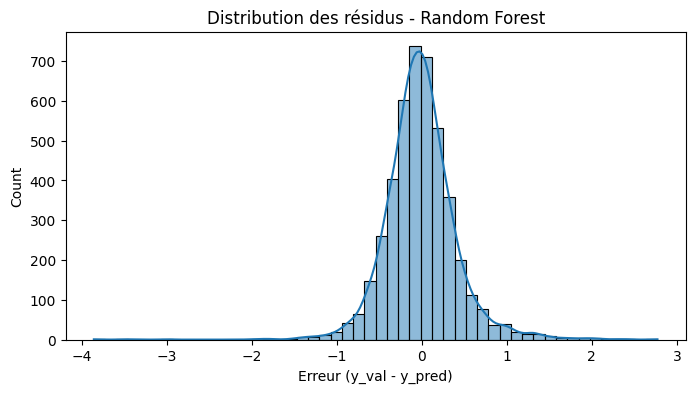

In [19]:
# 4. R√©sidus (erreurs)
residuals = y_val - y_pred_rf

plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Distribution des r√©sidus - Random Forest")
plt.xlabel("Erreur (y_val - y_pred)")
plt.show()

Commentaires : La majorit√© des r√©sidus sont proches de **0**, ce qui montre que le mod√®le pr√©dit bien.
- La distribution est **sym√©trique et centr√©e**, avec peu d‚Äôerreurs extr√™mes.
- Cela indique que le mod√®le Random Forest est **stable et √©quilibr√©**.

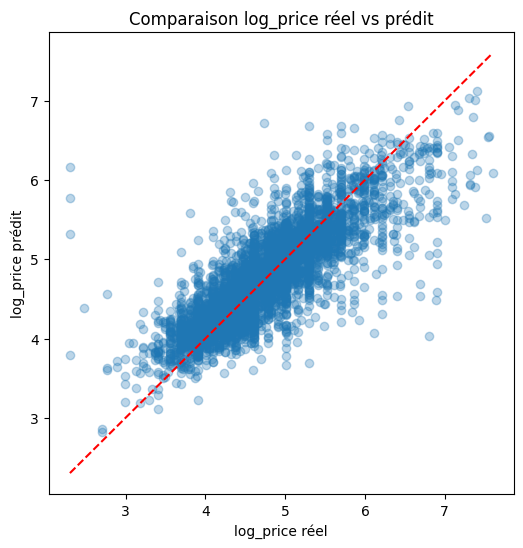

In [16]:
# 5.Comparaison vraie vs pr√©dite
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_rf, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("log_price r√©el")
plt.ylabel("log_price pr√©dit")
plt.title("Comparaison log_price r√©el vs pr√©dit")
plt.show()

Commentaires : Les pr√©dictions suivent bien la diagonale, ce qui montre que le mod√®le est **globalement pr√©cis**.
- On observe quelques **sous-estimations** pour les logements tr√®s chers.
- Le mod√®le capte bien la tendance g√©n√©rale entre `log_price r√©el` et `log_price pr√©dit`.

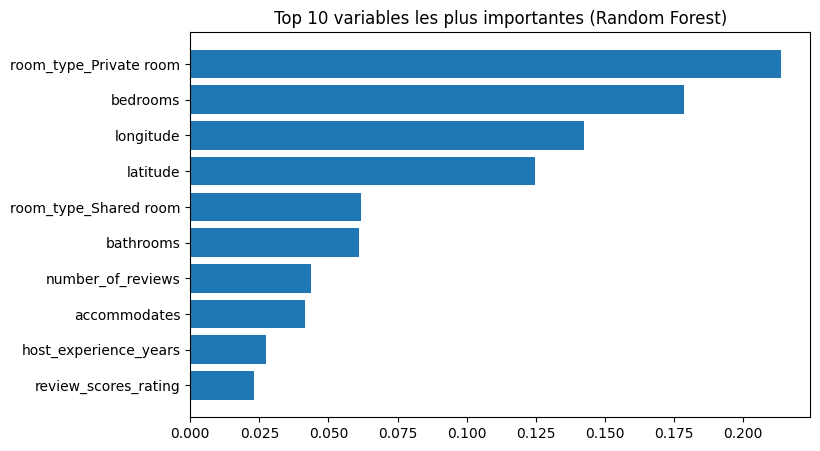

In [17]:
# 6. Feature importance
importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]  # top 10

plt.figure(figsize=(8,5))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title("Top 10 variables les plus importantes (Random Forest)")
plt.show()


Commentaires : La variable la plus influente est `room_type_Private room`, suivie par `bedrooms` et la position (`longitude`, `latitude`).
- Le **type de chambre** et le **nombre de pi√®ces** sont essentiels pour expliquer le prix.
- D'autres variables comme les avis et l'anciennet√© de l‚Äôh√¥te ont un impact plus faible.

## Mod√®le XGBoost

In [20]:
# Installation de xgboost
!pip install -q xgboost

In [21]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [23]:
# 1.  Mod√®le XGBoost
xgbr = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgbr.fit(X_train, y_train)

# 2.  Pr√©dictions
y_pred_xgb = xgbr.predict(X_val)

# 3.  RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_xgb))
print(f" RMSE (XGBoost) : {rmse_xgb:.4f}")

 RMSE (XGBoost) : 0.4051


Commentaires :  Le mod√®le XGBoost est le plus performant avec un **RMSE de 0.4051**, mieux que la r√©gression lin√©aire (0.4902) et Random Forest (0.4146).

Il sera utilis√© pour g√©n√©rer les pr√©dictions finales sur les logements test (`airbnb_test.csv`).

Le mod√®le est **stable, pr√©cis et interpr√©table**, avec une bonne gestion des r√©sidus et une bonne capacit√© √† capturer la variabilit√© des prix.

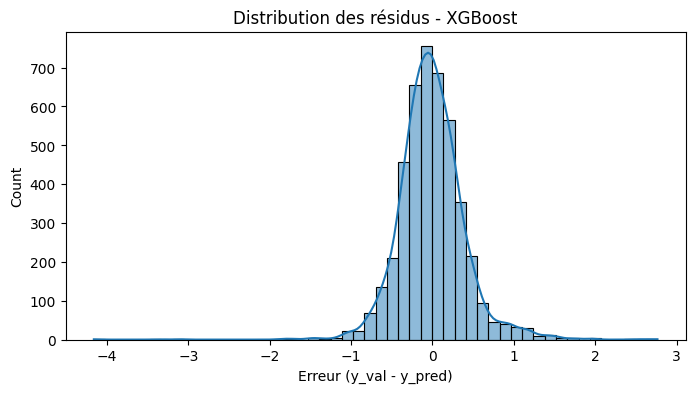

In [24]:
# 4. R√©sidus
residuals_xgb = y_val - y_pred_xgb

plt.figure(figsize=(8, 4))
sns.histplot(residuals_xgb, bins=50, kde=True)
plt.title("Distribution des r√©sidus - XGBoost")
plt.xlabel("Erreur (y_val - y_pred)")
plt.show()

Commentaires : Les r√©sidus sont bien **centr√©s autour de 0**.
- La forme est sym√©trique et fine ‚Üí le mod√®le est **pr√©cis et stable**.
- XGBoost semble faire **moins d‚Äôerreurs extr√™mes** que Random Forest.

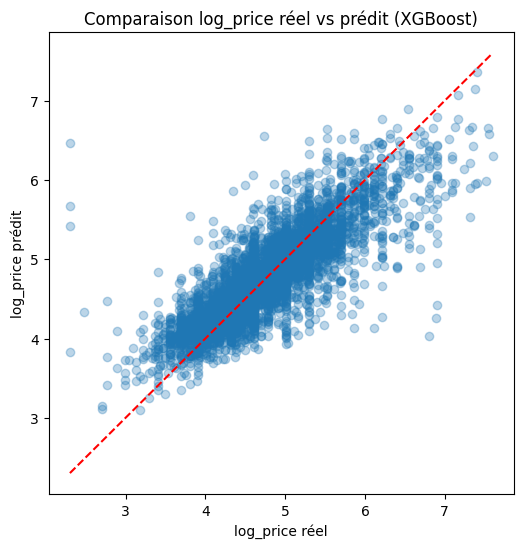

In [25]:
# 5. y_val vs y_pred
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_pred_xgb, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("log_price r√©el")
plt.ylabel("log_price pr√©dit")
plt.title("Comparaison log_price r√©el vs pr√©dit (XGBoost)")
plt.show()

Commentaires :  Les pr√©dictions XGBoost suivent bien la diagonale, ce qui montre une bonne pr√©cision.
- Il y a **moins de dispersion** qu‚Äôavec les autres mod√®les.
- Le mod√®le semble **mieux capter les extr√™mes** que Random Forest.

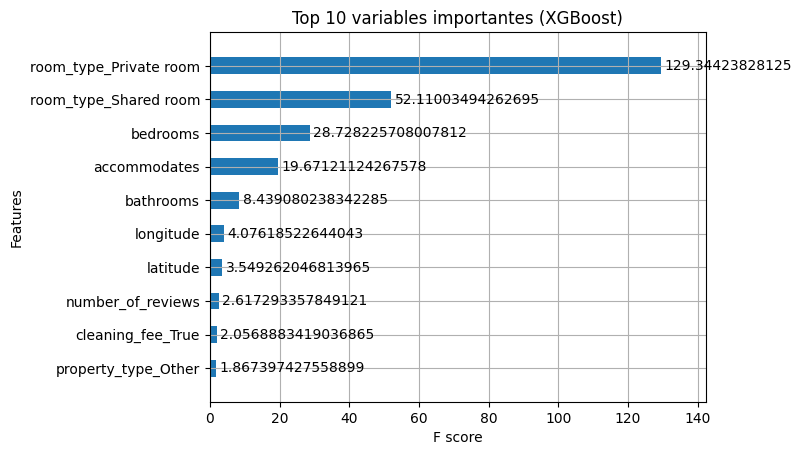

In [26]:
# 6. Feature importance
xgb.plot_importance(xgbr, max_num_features=10, importance_type='gain', height=0.5)
plt.title("Top 10 variables importantes (XGBoost)")
plt.show()


Commentaires : Le type de chambre (`room_type_Private room`) est **de loin la variable la plus influente**.
- `room_type_Shared room` et `bedrooms` suivent, comme dans le mod√®le Random Forest.
- XGBoost confirme que la **capacit√© du logement** et son **type** sont des facteurs cl√©s pour pr√©dire le prix.

## Pr√©dictions sur airbnb_test.csv avec **XGBoost**

In [27]:
# Charger les donn√©es de test
df_test = pd.read_csv('airbnb_test.csv')
df_test_orig = df_test.copy()  # pour r√©cup√©rer l'id plus tard

# M√™me pr√©traitement que pour le train

# Nettoyage de host_response_rate
df_test['host_response_rate'] = df_test['host_response_rate'].str.rstrip('%').astype(float)

# Dates
df_test['host_since'] = pd.to_datetime(df_test['host_since'])
df_test['first_review'] = pd.to_datetime(df_test['first_review'])
df_test['last_review'] = pd.to_datetime(df_test['last_review'])

# Anciennet√© de l'h√¥te
df_test['host_experience_years'] = pd.to_datetime("2018-01-01") - df_test['host_since']
df_test['host_experience_years'] = df_test['host_experience_years'].dt.days // 365

# Imputation
df_test['bathrooms'] = df_test['bathrooms'].fillna(df_test['bathrooms'].median())
df_test['bedrooms'] = df_test['bedrooms'].fillna(df_test['bedrooms'].median())
df_test['beds'] = df_test['beds'].fillna(df_test['beds'].median())
df_test['review_scores_rating'] = df_test['review_scores_rating'].fillna(df_test['review_scores_rating'].median())
df_test['host_response_rate'] = df_test['host_response_rate'].fillna(df_test['host_response_rate'].median())
df_test['zipcode'] = df_test['zipcode'].fillna("unknown")
df_test['neighbourhood'] = df_test['neighbourhood'].fillna("unknown")
df_test['host_experience_years'] = df_test['host_experience_years'].fillna(0)

In [28]:
# Encodage des m√™mes colonnes que dans le train
df_test[categorical_cols] = df_test[categorical_cols].astype(str)
df_test_encoded = pd.get_dummies(df_test[categorical_cols], drop_first=True)

# Ajouter les colonnes num√©riques
df_test_model = pd.concat([df_test, df_test_encoded], axis=1)
df_test_model.drop(columns=categorical_cols, inplace=True)

# Alignement des colonnes avec le train
df_test_model = df_test_model.reindex(columns=X.columns, fill_value=0)


In [31]:
# Pr√©dictions finales avec XGBoost
y_test_pred = xgbr.predict(df_test_model)

# Cr√©ation du fichier final
prediction_df = pd.DataFrame({
    'id': df_test_orig['Unnamed: 0'],
    'prediction': y_test_pred  # log_price directement
})

# Sauvegarde du fichier
prediction_df.to_csv('prediction.csv', index=False)


Commentaires : Le mod√®le XGBoost a √©t√© retenu pour sa performance (RMSE = 0.4051).  
Il a permis de produire les pr√©dictions finales sur les annonces Airbnb inconnues.  
Toutes les √©tapes du projet ont √©t√© r√©alis√©es dans le respect des consignes (EDA, preprocessing, mod√©lisation, export).

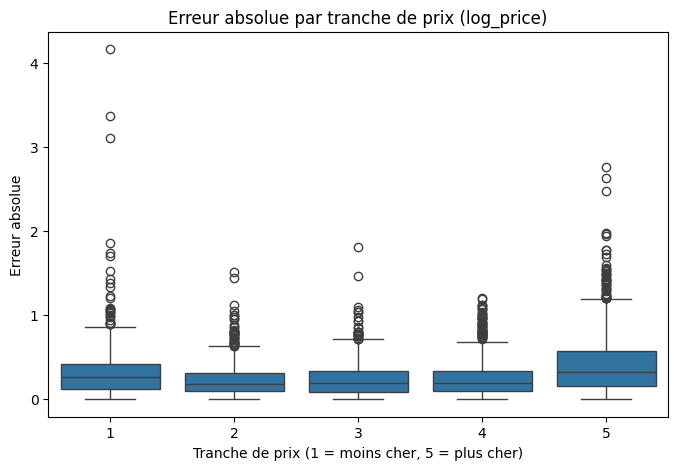

In [35]:
# Cr√©er les erreurs absolues
error_abs = np.abs(y_val - y_pred_xgb)

# Regrouper les valeurs r√©elles de log_price en 5 tranches (quantiles)
price_bins = pd.qcut(y_val, q=5, labels=["1", "2", "3", "4", "5"])

# Cr√©er un DataFrame pour la visualisation
error_df = pd.DataFrame({'log_price': y_val, 'abs_error': error_abs, 'price_bin': price_bins})

# Afficher un boxplot de l'erreur par tranche de prix
plt.figure(figsize=(8,5))
sns.boxplot(x='price_bin', y='abs_error', data=error_df)
plt.title("Erreur absolue par tranche de prix (log_price)")
plt.xlabel("Tranche de prix (1 = moins cher, 5 = plus cher)")
plt.ylabel("Erreur absolue")
plt.show()

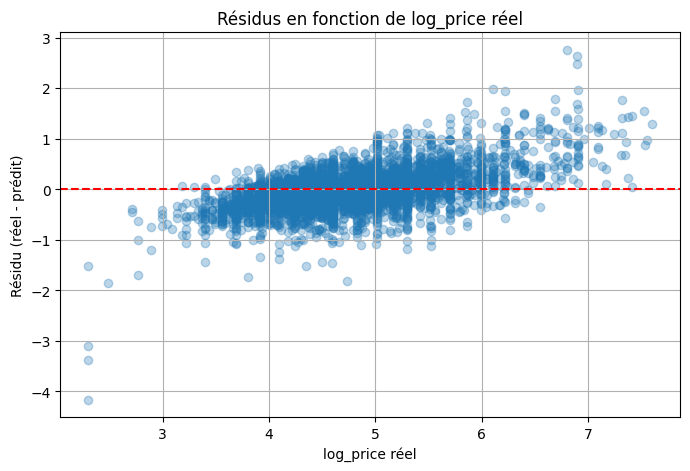

In [36]:
plt.figure(figsize=(8,5))
plt.scatter(y_val, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("R√©sidus en fonction de log_price r√©el")
plt.xlabel("log_price r√©el")
plt.ylabel("R√©sidu (r√©el - pr√©dit)")
plt.grid(True)
plt.show()


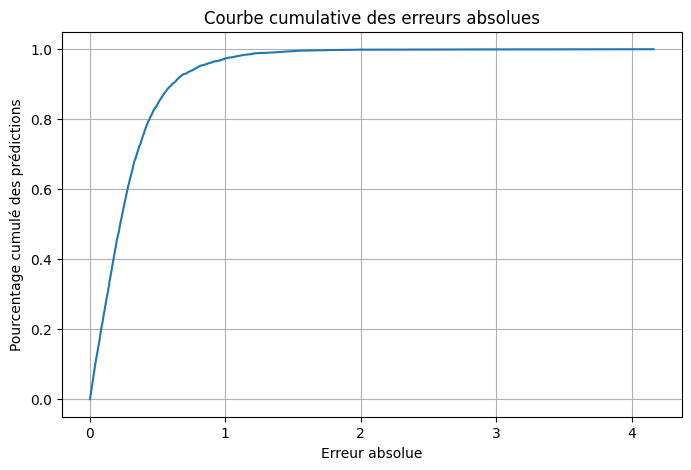

In [37]:
errors_sorted = np.sort(np.abs(y_val - y_pred_xgb))
cumulative = np.arange(len(errors_sorted)) / len(errors_sorted)

plt.figure(figsize=(8,5))
plt.plot(errors_sorted, cumulative)
plt.title("Courbe cumulative des erreurs absolues")
plt.xlabel("Erreur absolue")
plt.ylabel("Pourcentage cumul√© des pr√©dictions")
plt.grid(True)
plt.show()


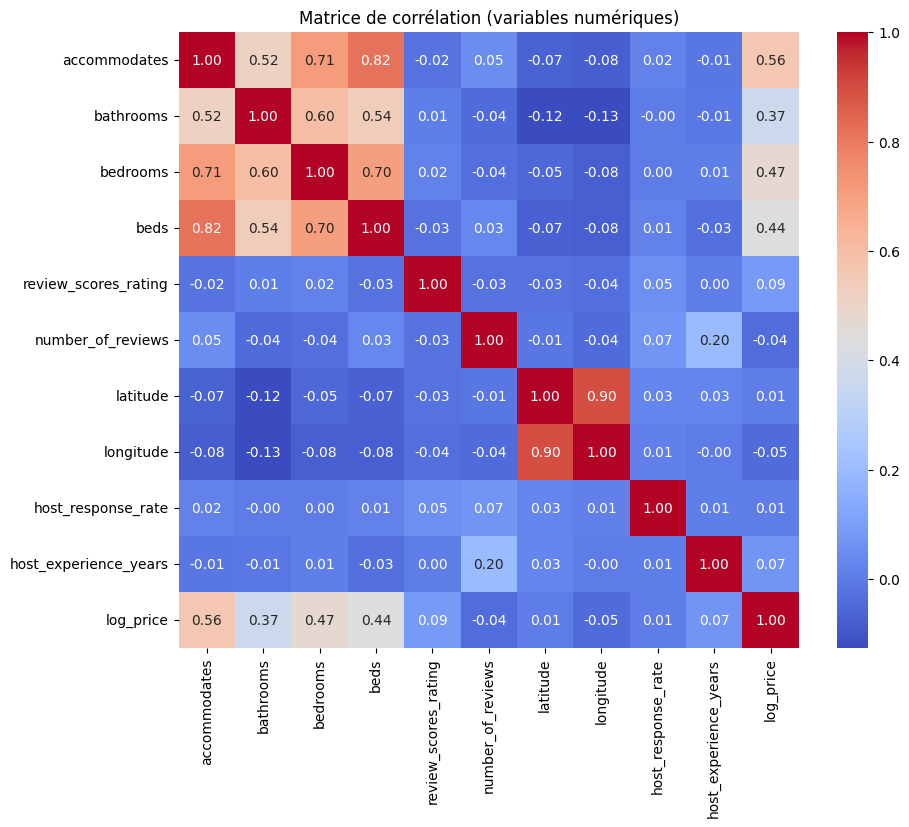

In [38]:
numeric_df = df_model[numerical_cols + ['log_price']]

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corr√©lation (variables num√©riques)")
plt.show()



## Les Mod√®les test√©s

| Mod√®le              | RMSE obtenu |
|---------------------|-------------|
| R√©gression lin√©aire | 0.4902      |
| Random Forest       | 0.4146      |
| XGBoost             | **0.4051**  |

XGBoost est retenu pour la **pr√©diction finale** sur le jeu de test.

---

## Fichier g√©n√©r√©

Le fichier final `prediction.csv` contient :
- `id` : identifiant de l‚Äôannonce
- `prediction` : log du prix pr√©dit

Format conforme au fichier `prediction_example.csv` fourni.